# Test Project: Traffic Volume


**Scenario:** I work as a Data Scientist for a cab app that operates in Ecuador. There, the company is mainly present in the capital Quito. To improve the user experience, the goal is to more accurately model how long passengers are likely to be stuck in traffic. To do this, your company has tracked how long the vehicle will be completely stuck for each trip. That's the variable to be calculated in advance. 

When passengers know in advance how long they will be stuck in traffic, they are better able to adjust to potentially long trip durations and experience the trip more positively. In addition, because the cost is calculated primarily by distance rather than by trip duration, these trips are not as lucrative as trips the cab might otherwise make.

The following background information about Quito might be helpful for the task:

* Since it is especially about the traffic within the city and the outskirts incl. the airport, we can assume that only the data within the following coordinates are relevant for the prediction:
    * Maximum and minimum latitude: `[-0.4,0.05]`
    * Maximum and minimum longitude: `[-78.6,-78.3]`
* Ecuador has the rainy season from October to May and the dry season from June to September.
* The speed limit is 50 km/h in the city and 70 km/h in the direction of the airport.

The goal is basically to calculate, how long will the cab spend in traffic based on daytime, location, etc.

Each row of the dataset corresponds to a cab ride in Quito, Ecuador. The data looks like this:

Column number | Column name | Data type | Description
 ------------ | :---------:             | :---------:                   | ------------:
0             | `'id'`                  | categorical  (`int`)          | A unique identification number for each line
1             | `'vendor_id'`           | categorical (`string`)        | Name of the booked cab company
2             | `'pickup_datetime'`     | continuous (`datetime`)   | Date and time of the start of the journey
3             | `'pickup_longitude'`    | continuous (`float`)      | Longitude at which the journey started
4             | `'pickup_latitude'`     | continuous (`float`)      | Latitude at which the journey started
5             | `'dropoff_longitude'`   | continuous (`float`)      | Longitude of the destination
6             | `'dropoff_latitude'`    | continuous (`float`)      | Latitude of the destination
7             | `'store_and_fwd_flag'`  | categorical                   | Indicates whether data was cached for a longer time (`Y`) or went directly to the server (`N`)
8             | `'trip_estimated'`      | continuous (`int`)        | Estimated travel time without taking traffic into account (seconds)
9            | `'distance_m'`          | continuous(`float`)        | Distance between pickup and arrival point
10            | `'wait_sec'`            | continuous (`int`)        | Duration, the passengers are stuck in traffic (seconds). During this time, the vehicle was completely stationary.

The objective of this project is to develop a model that predicts `wait_sec` as well as possible.

In [314]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from datetime import datetime
from math import radians, sin, cos, sqrt, atan2
import pickle

## EDA - Exploratory data analysis


In [3]:
# load data
df_train = pd.read_csv("data_train.csv", 
                       parse_dates = ["pickup_datetime"], 
                       dtype={"store_and_fwd_flag": "category"})

# check for duplicated IDs
if df_train["id"].nunique() == len(df_train):
    df_train = df_train.set_index("id")
else:
    print("DataFrame contains duplicated IDs")
    print("Manual control needed")

df_train.head()

,vendor_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_estimated,distance_m,wait_sec
id,,,,,,,,,,
0,Quito,2016-08-25 12:40:00,-78.411326,-0.309814,-78.455283,-0.287551,N,678,7363.299869,38
1,Quito,2016-12-17 05:29:50,-78.512510,-0.221165,-78.478725,-0.196938,N,750,6450.734909,210
2,Quito,2017-03-16 05:36:36,-78.467560,-0.163823,-78.483523,-0.094844,N,1274,9445.014567,666
3,Quito,2016-10-20 09:25:57,-78.472038,-0.139989,-78.494747,-0.169194,N,615,5772.514970,312
4,Quito,2016-12-01 12:58:06,-78.493910,-0.176009,-78.504876,-0.180504,N,308,1719.218262,70


In [4]:
pd.set_option("display.float_format", "{:.2f}".format)
display(df_train.info(), 
        df_train.isna().sum(),
        df_train.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15657 entries, 0 to 15656
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   vendor_id           15657 non-null  object        
 1   pickup_datetime     15657 non-null  datetime64[ns]
 2   pickup_longitude    15657 non-null  float64       
 3   pickup_latitude     15657 non-null  float64       
 4   dropoff_longitude   15657 non-null  float64       
 5   dropoff_latitude    15657 non-null  float64       
 6   store_and_fwd_flag  15657 non-null  category      
 7   trip_estimated      15657 non-null  int64         
 8   distance_m          15657 non-null  float64       
 9   wait_sec            15657 non-null  int64         
dtypes: category(1), datetime64[ns](1), float64(5), int64(2), object(1)
memory usage: 1.2+ MB


None

vendor_id             0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_estimated        0
distance_m            0
wait_sec              0
dtype: int64

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_estimated,distance_m,wait_sec
count,15657.00,15657.00,15657.00,15657.00,15657.00,15657.00,15657.00
mean,-78.49,-0.19,-78.49,-0.19,1073.20,5447.24,304.48
std,0.03,0.06,0.03,0.06,24093.60,4777.75,284.18
min,-79.91,-2.11,-79.89,-2.16,-1844.00,8.00,0.00
25%,-78.51,-0.21,-78.50,-0.22,313.00,2442.10,108.00
50%,-78.49,-0.18,-78.49,-0.18,514.00,4128.48,222.00
75%,-78.47,-0.15,-78.48,-0.15,828.00,6886.89,404.00
max,-78.17,0.34,-78.13,0.35,1980260.00,92322.76,1929.00


In [5]:
# no NaNs, correct dtypes
# latitude / longitude values outside the city
# trip estimated - negative min and too big max val (550 hours...)
# check min / max distance

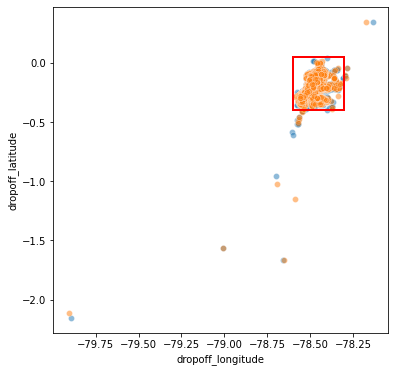

In [6]:
MAX_LAT = 0.05
MIN_LAT = -0.4
MAX_LON = -78.3
MIN_LON = -78.6

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
sns.scatterplot(data = df_train, x = "dropoff_longitude", y = "dropoff_latitude", alpha = 0.5, ax = ax)
sns.scatterplot(data = df_train, x = "pickup_longitude", y = "pickup_latitude", alpha = 0.5, ax = ax)
ax.plot([MIN_LON, MIN_LON], [MIN_LAT, MAX_LAT], color='red', linewidth=2)
ax.plot([MAX_LON, MAX_LON], [MIN_LAT, MAX_LAT], color='red', linewidth=2)
ax.plot([MIN_LON, MAX_LON], [MIN_LAT, MIN_LAT], color='red', linewidth=2)
ax.plot([MAX_LON, MIN_LON], [MAX_LAT, MAX_LAT], color='red', linewidth=2)

# Only traffic in the city and around airport is to be considered 

In [7]:
# remove the rides outside the city
mask_city = ((df_train['pickup_longitude'] < MAX_LON) & 
             (df_train['pickup_longitude'] > MIN_LON) &
             (df_train['dropoff_longitude'] < MAX_LON) & 
             (df_train['dropoff_longitude'] > MIN_LON) &
             (df_train['pickup_latitude'] < MAX_LAT) & 
             (df_train['pickup_latitude'] > MIN_LAT) &
             (df_train['dropoff_latitude'] < MAX_LAT) & 
             (df_train['dropoff_latitude'] > MIN_LAT))

print(f"{mask_city.sum()} out of {len(df_train)} rides takes place in the city")

df_train = df_train[mask_city]

15631 out of 15657 rides takes place in the city


In [8]:
# store_and_fwd_flag column
print(df_train["store_and_fwd_flag"].value_counts())
# the way the data is stored doesnt affect the prediction

N    15631
Name: store_and_fwd_flag, dtype: int64


In [9]:
# check vendor_id column
display(print(df_train["vendor_id"].value_counts()),
        df_train.groupby("vendor_id").mean(),
        df_train.groupby("vendor_id").median())

# medians of all three vendors similar, means strongly influenced by outliers

Quito                     15443
Quito Cabify Lite           159
Quito Cabify Executive       29
Name: vendor_id, dtype: int64


None

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_estimated,distance_m,wait_sec
vendor_id,,,,,,,
Quito,-78.49,-0.19,-78.49,-0.19,925.97,5415.81,305.20
Quito Cabify Executive,-78.49,-0.18,-78.49,-0.18,64340.55,4162.24,247.34
Quito Cabify Lite,-78.49,-0.18,-78.49,-0.18,3670.18,5805.22,246.40


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_estimated,distance_m,wait_sec
vendor_id,,,,,,,
Quito,-78.49,-0.18,-78.49,-0.18,514,4121.07,224
Quito Cabify Executive,-78.48,-0.18,-78.49,-0.18,438,3201.73,115
Quito Cabify Lite,-78.49,-0.19,-78.49,-0.18,525,4183.26,149


<AxesSubplot:>

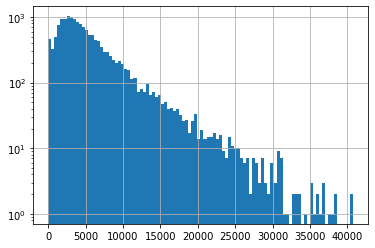

In [10]:
# distance_m column
df_train["distance_m"].hist(bins = 100, log = True)

# distribution makes sense, many short and few long trips

<AxesSubplot:>

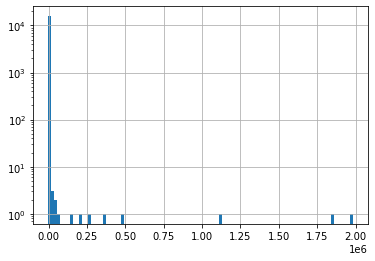

In [11]:
# trip_estimated column
df_train["trip_estimated"].hist(log = True, bins = 100)

# few nonsense outliers --- max value is 550 hours...

In [12]:
weird_data = df_train.loc[(df_train["trip_estimated"] <= 0) | (df_train["trip_estimated"] > 10000), "trip_estimated"]
df_train.loc[weird_data.index, :]

,vendor_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_estimated,distance_m,wait_sec
id,,,,,,,,,,
205,Quito,2016-08-31 09:52:38,-78.50,-0.19,-78.48,-0.17,N,1980260,4688.66,815
289,Quito,2016-10-27 09:30:21,-78.38,-0.21,-78.39,-0.19,N,28907,3579.21,31
3691,Quito,2017-06-19 09:03:39,-78.49,-0.21,-78.49,-0.21,N,13594,91.13,2
3805,Quito Cabify Lite,2017-02-28 08:57:41,-78.47,-0.13,-78.54,-0.27,N,482022,22929.88,148
5320,Quito,2017-06-13 08:01:30,-78.56,-0.29,-78.56,-0.27,N,46308,2445.22,461
6727,Quito,2017-07-13 06:17:13,-78.51,-0.28,-78.50,-0.26,N,49786,3232.79,36
7257,Quito,2017-05-11 11:32:15,-78.48,-0.13,-78.48,-0.12,N,359723,264.42,0
7440,Quito,2017-05-12 07:09:05,-78.44,-0.09,-78.44,-0.09,N,69754,65.09,1346
9541,Quito Cabify Executive,2017-05-26 02:14:25,-78.49,-0.17,-78.49,-0.20,N,1851662,3552.96,728


### Outlier Detection

[(0.0, 10000.0), (0.0, 95000.0)]

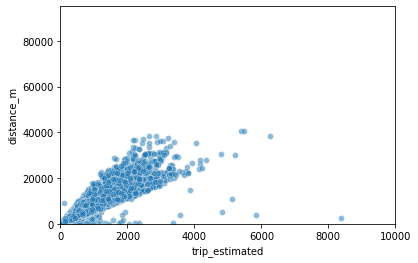

In [13]:
sns.scatterplot(data = df_train, x = "trip_estimated", y = "distance_m", alpha = 0.5).set(xlim=(0, 10000), ylim=(0, 95000))

<AxesSubplot:>

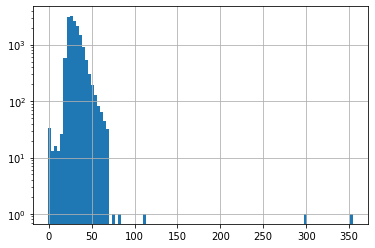

In [14]:
df_train["km/h"] = (df_train["distance_m"] * 3.6) / df_train["trip_estimated"]
df_train["km/h"].hist(log = True, bins = 100)

Number of outliers with km/h value under 20: 115
Number of outliers with km/h value above 70: 5


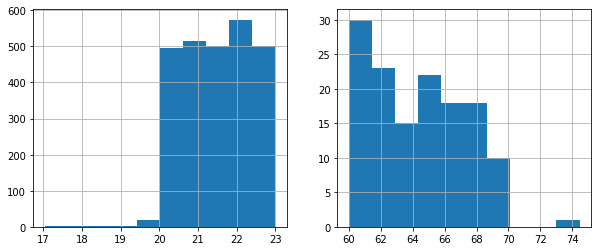

In [15]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
df_train.loc[(df_train["km/h"] > 17) & (df_train["km/h"] <= 23), "km/h"].hist(bins = 10, ax = ax[0], log = False)
df_train.loc[(df_train["km/h"] > 60) & (df_train["km/h"] <= 75), "km/h"].hist(bins = 10, ax = ax[1], log = False)
print(f"Number of outliers with km/h value under 20: {df_train.loc[df_train['km/h'] < 20, 'km/h'].count()}")
print(f"Number of outliers with km/h value above 70: {df_train.loc[df_train['km/h'] > 70, 'km/h'].count()}")

# data points with "km/h" value outside of the <20 ; 70> interval will be dropped
mask_outliers_kmh = (df_train["km/h"] < 20) | (df_train["km/h"] > 70)

[(0.0, 10000.0), (0.0, 80000.0)]

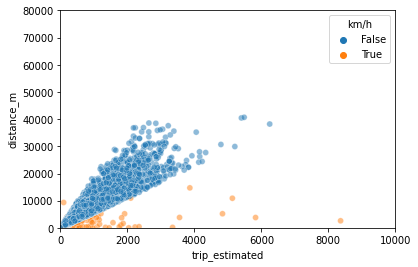

In [16]:
sns.scatterplot(data = df_train, x = "trip_estimated", y = "distance_m", alpha = 0.5, hue = mask_outliers_kmh).set(xlim=(0, 10000), ylim=(0, 80000))

In [17]:
# mask for rides outside the city: mask_city
# mask for outliers with wrong trip_estimated value: mask_outliers_kmh

df_train = df_train[~mask_outliers_kmh]

### Check correlations

<AxesSubplot:>

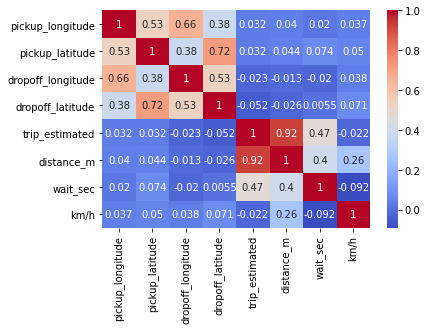

In [18]:
sns.heatmap(df_train.corr(), annot = True, cmap='coolwarm')

# high correlation between latitude-latitude and longitude-longitude
# 1) remove one 2) use PCA 3) ridge or lasso 4) ignore

# high correlation between distance and trip estimated
# 1) use km/h feature only

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_estimated,distance_m,wait_sec,km/h
count,15511.00,15511.00,15511.00,15511.00,15511.00,15511.00,15511.00,15511.00
mean,-78.49,-0.19,-78.49,-0.19,643.85,5441.15,304.12,30.57
std,0.03,0.06,0.03,0.06,508.48,4629.85,282.77,8.22
min,-78.58,-0.39,-78.58,-0.40,1.00,14.92,0.00,20.00
25%,-78.51,-0.21,-78.50,-0.22,313.00,2470.99,109.00,24.41
50%,-78.49,-0.18,-78.49,-0.18,514.00,4146.31,223.00,28.82
75%,-78.47,-0.15,-78.48,-0.15,824.00,6900.76,404.00,34.70
max,-78.32,0.01,-78.31,0.04,6249.00,40691.04,1929.00,69.90


<AxesSubplot:xlabel='dropoff_longitude', ylabel='dropoff_latitude'>

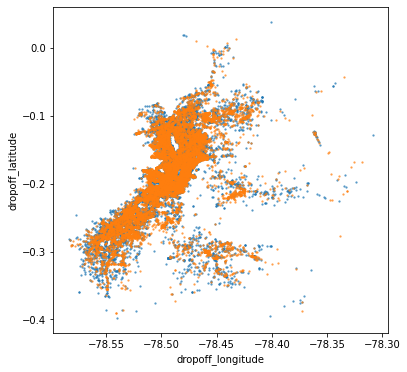

In [19]:
display(df_train.describe())
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
sns.scatterplot(data = df_train, x = "dropoff_longitude", y = "dropoff_latitude", alpha = 0.75, ax = ax, s = 5, linewidth=0)
sns.scatterplot(data = df_train, x = "pickup_longitude", y = "pickup_latitude", alpha = 0.75, ax = ax, s = 5, linewidth=0)

In [20]:
df = pd.read_csv("data_train.csv", index_col =  "id")
df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 42)

In [21]:
df_train.head()

,vendor_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_estimated,distance_m,wait_sec
id,,,,,,,,,,
10198,Quito,2016-08-19 11:07:05,-78.49,-0.15,-78.49,-0.17,N,271,3051.50,227
3482,Quito,2017-01-24 08:16:53,-78.49,-0.21,-78.53,-0.24,N,1285,7668.89,603
7760,Quito,2017-07-18 10:08:14,-78.51,-0.25,-78.52,-0.25,N,391,2268.81,220
13622,Quito,2017-04-22 02:20:57,-78.49,-0.18,-78.50,-0.18,N,286,2839.05,44
7188,Quito,2016-07-08 09:36:10,-78.53,-0.25,-78.55,-0.32,N,1532,9679.17,621


In [22]:
df_test.shape

(1566, 10)

## Data Preparation

### Datatype Transformation

In [23]:
# transform datatypes of df_train

df_train = df_train.drop(["store_and_fwd_flag"], axis = 1)
df_train[["vendor_id"]] = df_train[["vendor_id"]].astype("category")
df_train["pickup_datetime"] = pd.to_datetime(df_train["pickup_datetime"])

In [24]:
# transform datatypes of df_test

df_test = df_test.drop(["store_and_fwd_flag"], axis = 1)
df_test[["vendor_id"]] = df_test[["vendor_id"]].astype("category")
df_test["pickup_datetime"] = pd.to_datetime(df_test["pickup_datetime"])

In [25]:
df_train.shape[0] + df_test.shape[0]

15657

### Data Cleaning

Define two Data Cleaning functions - one for train and one for test/aim data.

In [444]:
def clean_data_train(df):
    """
    FOR TRAIN DATA ONLY - DROPS DUPLICATES
    This function takes pd.DataFrame, removes NaNs, unused columns, drops duplicates and changes datatypes.
    Returns cleaned pd.DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.dropna()
    df.index = df["id"]
    df = df.drop(["id", "store_and_fwd_flag"], axis = 1)
    df[["vendor_id"]] = df[["vendor_id"]].astype("category")
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    df = df.drop_duplicates()
    return df

def clean_data_test_aim(df):
    """
    This function takes pd.DataFrame, removes NaNs, unused columns, drops duplicates and changes datatypes.
    Returns cleaned pd.DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.dropna()
    df.index = df["id"]
    df = df.drop(["id", "store_and_fwd_flag"], axis = 1)
    df[["vendor_id"]] = df[["vendor_id"]].astype("category")
    df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])
    return df

In [27]:
df = pd.read_csv("data_train.csv")
df = clean_data_train(df)
df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_estimated,distance_m,wait_sec
count,15388.00,15388.00,15388.00,15388.00,15388.00,15388.00,15388.00
mean,-78.49,-0.19,-78.49,-0.19,1079.65,5438.54,304.10
std,0.03,0.06,0.03,0.06,24303.13,4766.37,284.35
min,-79.91,-2.11,-79.89,-2.16,-1844.00,8.00,0.00
25%,-78.51,-0.21,-78.50,-0.22,313.00,2438.86,108.00
50%,-78.49,-0.18,-78.49,-0.18,514.00,4125.00,222.00
75%,-78.47,-0.15,-78.48,-0.15,827.00,6883.32,404.00
max,-78.17,0.34,-78.13,0.35,1980260.00,92322.76,1929.00


In [28]:
def city_only_data(df):
    """
    This function takes pd.DataFrame and removes rides with any pickup or dropoff point outside the city.
    Returns pd.DataFrame with rides inside the city only.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    MAX_LAT = 0.05
    MIN_LAT = -0.4
    MAX_LON = -78.3
    MIN_LON = -78.6

    mask_city = ((df['pickup_longitude'] < MAX_LON) & 
                 (df['pickup_longitude'] > MIN_LON) &
                 (df['dropoff_longitude'] < MAX_LON) & 
                 (df['dropoff_longitude'] > MIN_LON) &
                 (df['pickup_latitude'] < MAX_LAT) & 
                 (df['pickup_latitude'] > MIN_LAT) &
                 (df['dropoff_latitude'] < MAX_LAT) & 
                 (df['dropoff_latitude'] > MIN_LAT))

    df = df[mask_city]
    
    return df

In [29]:
def generate_kmh_col(df):
    """
    This function takes pd.DataFrame, creates new "km/h" feature, and removes the outliers based on the empiric criteria.
    Returns clean pd.DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.copy()
    df.loc[:, "km/h"] = ((df["distance_m"] * 3.6) / df["trip_estimated"])
        
    return df

In [30]:
def remove_kmh_outliers(df):
    """
    This function takes pd.DataFrame and removes the outliers based on the km/h value.
    Returns clean pd.DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.copy()
    mask_outliers_kmh = (df["km/h"] < 20) | (df["km/h"] > 70)
    df = df[~mask_outliers_kmh]
    
    return df

In [31]:
def impute_kmh_outliers(df):
    """
    This function takes pd.DataFrame and imputes the outliers based on the km/h value.
    Returns clean pd.DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.copy()
    median_kmh = df["km/h"].median()    
    mask_outliers_kmh = ((df["km/h"] < 20) | (df["km/h"] > 70))
    df.loc[mask_outliers_kmh, "km/h"] = median_kmh
    df.loc[mask_outliers_kmh, "trip_estimated"] = (df["distance_m"] * 3.6) / df["km/h"]
    
    return df

In [32]:
def sampling_data(df):
    """
    FOR TRAINING DATA ONLY
    This function takes pd.DataFrame, removes rides outside the city, outliers, cleans data,
    adds km/h feature, removes its outliers.
    Returns pd.DataFrame clean TRAINING dataframe.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = city_only_data(df)
    df = generate_kmh_col(df)
    df = remove_kmh_outliers(df)
    
    return df

In [33]:
def prepare_test_aim_data(df):
    """
    FOR TEST AND AIM DATA ONLY
    This function takes pd.DataFrame, removes rides outside the city, outliers, cleans data,
    adds km/h feature, imputes its outliers.
    Returns pd.DataFrame clean TEST or AIM dataframe.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = city_only_data(df)
    df = generate_kmh_col(df)
    df = impute_kmh_outliers(df)
    
    return df

## Modeling

### Build different basic models

Building few basic models without any optimization, using just the basic features, to see where I am at. 

In [34]:
# TRAIN data has to be processed as follows:
# clean_data(df)
# sampling_data(df)

# TEST data has to be processed as follows:
# clean_data(df)
# prepare_test_aim_data(df)

df = pd.read_csv("data_train.csv")

df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 42)

# TRAIN DATA
df_train = clean_data_train(df_train)
df_train = sampling_data(df_train)

# TEST DATA
df_test = clean_data_test_aim(df_test)
df_test = prepare_test_aim_data(df_test)

In [35]:
# BASIC MODEL

feat_cols = ["pickup_longitude", 
             "pickup_latitude", 
             "dropoff_longitude", 
             "dropoff_latitude",
             "trip_estimated", 
             "distance_m", 
             "km/h"]

features_train = df_train[feat_cols]
target_train = df_train["wait_sec"]

features_test = df_test[feat_cols]
target_test = df_test["wait_sec"]

scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

basic_model_lin = LinearRegression()
basic_model_lin.fit(features_train_scaled, target_train)
target_train_pred = basic_model_lin.predict(features_train_scaled)
target_test_pred = basic_model_lin.predict(features_test_scaled)

print(f"Linear Regression")
print(f"TRAIN ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_train, target_train_pred)}")
print(f"mean_squared_error: {mean_squared_error(target_train, target_train_pred)}")
print(f"r2_score: {r2_score(target_train, target_train_pred)}")
print(f"TEST ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_test, target_test_pred)}")
print(f"mean_squared_error: {mean_squared_error(target_test, target_test_pred)}")
print(f"r2_score: {r2_score(target_test, target_test_pred)}")

Linear Regression
TRAIN ACCURACY:
mean_absolute_error: 169.14299721596618
mean_squared_error: 61357.471382163836
r2_score: 0.2321965175305546
TEST ACCURACY:
mean_absolute_error: 164.39872887201528
mean_squared_error: 58418.74142795515
r2_score: 0.2941048414503711


In [36]:
basic_model_ridge = Ridge(alpha = 1)
basic_model_ridge.fit(features_train_scaled, target_train)
target_train_pred = basic_model_ridge.predict(features_train_scaled)
target_test_pred = basic_model_ridge.predict(features_test_scaled)

print(f"Ridge")
print(f"TRAIN ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_train, target_train_pred)}")
print(f"mean_squared_error: {mean_squared_error(target_train, target_train_pred)}")
print(f"r2_score: {r2_score(target_train, target_train_pred)}")
print(f"TEST ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_test, target_test_pred)}")
print(f"mean_squared_error: {mean_squared_error(target_test, target_test_pred)}")
print(f"r2_score: {r2_score(target_test, target_test_pred)}")

Ridge
TRAIN ACCURACY:
mean_absolute_error: 169.14625697926036
mean_squared_error: 61357.47572578351
r2_score: 0.23219646317619091
TEST ACCURACY:
mean_absolute_error: 164.40361908094812
mean_squared_error: 58422.35100401769
r2_score: 0.29406122561400294


In [37]:
basic_model_lasso = Lasso(alpha = 1)
basic_model_lasso.fit(features_train_scaled, target_train)
target_train_pred = basic_model_lasso.predict(features_train_scaled)
target_test_pred = basic_model_lasso.predict(features_test_scaled)

print(f"Lasso")
print(f"TRAIN ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_train, target_train_pred)}")
print(f"mean_squared_error: {mean_squared_error(target_train, target_train_pred)}")
print(f"r2_score: {r2_score(target_train, target_train_pred)}")
print(f"TEST ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_test, target_test_pred)}")
print(f"mean_squared_error: {mean_squared_error(target_test, target_test_pred)}")
print(f"r2_score: {r2_score(target_test, target_test_pred)}")

Lasso
TRAIN ACCURACY:
mean_absolute_error: 169.5174578001115
mean_squared_error: 61406.934832120525
r2_score: 0.2315775511964442
TEST ACCURACY:
mean_absolute_error: 164.97884262786116
mean_squared_error: 58808.766458252954
r2_score: 0.2893920254281376


### Feature Engineering

The dataset already offers many features. However, its good to "engineer" some new ones to see, if they make an impact and improve r2 score and other metrics of the model. 

In [38]:
df_train.head()

# vendor_id - onehotencode
# pickup_datetime - date - rainseason
# pickup_datetime - time - minutes .... we dont know if its AM or PM, lets make simply minutes since 00...
# pickup_datetime - weekend
# haversine distance - how long the journey is
# distance to center??
# latitude diff
# longitude diff


,vendor_id,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_estimated,distance_m,wait_sec,km/h
id,,,,,,,,,,
10198,Quito,2016-08-19 11:07:05,-78.49,-0.15,-78.49,-0.17,271,3051.50,227,40.54
3482,Quito,2017-01-24 08:16:53,-78.49,-0.21,-78.53,-0.24,1285,7668.89,603,21.48
7760,Quito,2017-07-18 10:08:14,-78.51,-0.25,-78.52,-0.25,391,2268.81,220,20.89
13622,Quito,2017-04-22 02:20:57,-78.49,-0.18,-78.50,-0.18,286,2839.05,44,35.74
7188,Quito,2016-07-08 09:36:10,-78.53,-0.25,-78.55,-0.32,1532,9679.17,621,22.74


In [40]:
def minutes_of_day(df):
    """
    This function takes pd.DataFrame and creates a new column "minutes_of_day" based on value from "pickup_datetime" column.
    Returns pd.DataFrame with new column "minutes_of_day" with number of minutes passed since noon 
    (or midnight, but based on data distribution it seems, that the data are PM - afternoon and evening).
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.copy()
    df['minutes_of_day'] = df['pickup_datetime'].dt.hour * 60 + df['pickup_datetime'].dt.minute - 60
    return df

In [41]:
def is_weekend(df):
    """
    This function takes pd.DataFrame and creates a new column "is_weekend" based on value from "pickup_datetime" column.
    Returns pd.DataFrame with new column "is_weekend" with values 0 (ride takes place from Monday to Friday)
    and 1 (ride takes place on Saturday or Sunday).
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.copy()
    df['is_weekend'] = (df['pickup_datetime'].dt.dayofweek // 5 == 1).astype(int)
    return df

In [42]:
def is_rainy_season(df):
    """
    This function takes pd.DataFrame and creates a new column "is_rainy_season" based on value from "pickup_datetime" column.
    Returns pd.DataFrame with new column "is_rainy_season" with values 0 (the month is June to September)
    and 1 (ride takes place in rainy season - October to May).
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.copy()
    df['is_rainy_season'] = df['pickup_datetime'].dt.month.map(lambda x: 1 if x in range(10,13) or x in range(1,6) else 0)
    return df

In [47]:
def process_pickup_datetime(df):
    """
    This function takes pd.DataFrame and runs it through the minutes_of_day(), is_weekend() and is_rainy_season() functions.
    Returns pd.DataFrame with new features. The original column "pickup_datetime" is dropped.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.copy()
    df = minutes_of_day(df)
    df = is_weekend(df)
    df = is_rainy_season(df)
    df = df.drop("pickup_datetime", axis = 1)
    return df

In [426]:
def onehot_vendor(df):
    # DONT USE THIS FUNCTION, CREATES ERRORS
    """
    This function takes pd.DataFrame and encodes the "vendor_id" column with onehotencoder.
    Returns pd.DataFrame with new columns (with 0/1 values) and without the original "vector_id" column.
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.copy()
    ohe = OneHotEncoder()
    one_hot_encoded = ohe.fit_transform(df[['vendor_id']])
    one_hot_encoded_array = one_hot_encoded.toarray()
    one_hot_df = pd.DataFrame(one_hot_encoded_array, columns=ohe.get_feature_names(['vendor_id']))
    df = pd.merge(df, one_hot_df, left_index=True, right_index=True)
    df = df.drop('vendor_id', axis=1)

    return df    

def vendor(df):
    """
    This function takes pd.DataFrame and creates the "Quito" column.
    Returns pd.DataFrame with "Quito" column with value 1 (Quito) or value 0 (all other vendors).
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    df = df.copy()
    vendor = (df.vendor_id == 'Quito').astype(int)
    vendor = vendor.astype(float)
    df['Quito'] = vendor
    df = df.drop(['vendor_id'], axis=1)

    return df  

In [428]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    
    Args: 
        lon1 (float) : longitude from start location
        lat1 (float) : latitude from start location
        lon2 (float) : longitude from end location
        lat2 (float) : longitude from end location
    
    Returns:
        float: distance between two points on earth
    """
    R = 6371.0  # radius of Earth in kilometers
    
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    return R * c

In [413]:
def process_lat_lon_cols(df):
    """
    This function takes pd.DataFrame and creates new features based on pickup/dropoff latitude/longitude columns.
    Returns pd.DataFrame with following new columns: "pickup_distance_to_center", 
    "dropoff_distance_to_center" and "to_center".
    
    Parameters:
    -----------
    df : pd.DataFrame
            
    Returns:
    --------
    df : pd.DataFrame
    
    """
    quito_center = (-0.175, -78.5)
    
    df["pickup_distance_to_center"] = (df[['pickup_latitude', 'pickup_longitude']].
                                       apply(lambda x: haversine(x[1], 
                                                                 x[0], 
                                                                 quito_center[1], 
                                                                 quito_center[0]), 
                                             axis=1))

    df["dropoff_distance_to_center"] = (df[['dropoff_latitude','dropoff_longitude']]
                                          .apply(lambda x: haversine(x[1], 
                                                                     x[0], 
                                                                     quito_center[1], 
                                                                     quito_center[0]),
                                                 axis=1))
    df["to_center"] = (df["pickup_distance_to_center"] > df["dropoff_distance_to_center"]).astype(int)
    

    return df

In [243]:
# TRAIN data has to be processed as follows:
# clean_data_train(df)
# sampling_data(df)
# process_pickup_datetime(df)
# vendor(df)
# process_lat_lon_cols(df)

# TEST data has to be processed as follows:
# clean_data_test_aim(df)
# prepare_test_aim_data(df)
# process_pickup_datetime(df)
# vendor(df)
# process_lat_lon_cols(df)

In [445]:
df = pd.read_csv("data_train.csv")

df_train, df_test = train_test_split(df, test_size = 0.1, random_state = 42)

# TRAIN DATA

df_train = clean_data_train(df_train)
df_train = sampling_data(df_train)
df_train = process_pickup_datetime(df_train)
df_train = vendor(df_train)
df_train = process_lat_lon_cols(df_train)

# TEST DATA

df_test = clean_data_test_aim(df_test)
df_test = prepare_test_aim_data(df_test)
df_test = process_pickup_datetime(df_test)
df_test = vendor(df_test)
df_test = process_lat_lon_cols(df_test)

In [253]:
feat_cols = ["pickup_longitude", 
             "pickup_latitude", 
             "dropoff_longitude", 
             "dropoff_latitude",
             "trip_estimated", 
             "distance_m", 
             "km/h",
             "minutes_of_day", 
             "is_weekend", 
             "is_rainy_season", 
             "vendor_id_Quito", 
             "vendor_id_Quito Cabify Executive", 
             "vendor_id_Quito Cabify Lite", 
             "pickup_distance_to_center", 
             "dropoff_distance_to_center", 
             "to_center"
            ]

### Train different optimized models

In [254]:
features_train = df_train[feat_cols]
target_train = df_train["wait_sec"]

features_test = df_test[feat_cols]
target_test = df_test["wait_sec"]

scaler = StandardScaler()
scaler.fit(features_train)
features_train_scaled = scaler.transform(features_train)
features_test_scaled = scaler.transform(features_test)

### LINEAR REGRESSION

In [283]:
# LINEAR REGRESSION

basic_model_lin = LinearRegression()
basic_model_lin.fit(features_train_scaled, target_train)
target_train_pred = basic_model_lin.predict(features_train_scaled)
target_test_pred = basic_model_lin.predict(features_test_scaled)

print(f"Linear Regression")
print(f"TRAIN ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_train, target_train_pred)}")
print(f"mean_squared_error: {mean_squared_error(target_train, target_train_pred)}")
print(f"r2_score: {r2_score(target_train, target_train_pred)}")
print(f"TEST ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_test, target_test_pred)}")
print(f"mean_squared_error: {mean_squared_error(target_test, target_test_pred)}")
print(f"r2_score: {r2_score(target_test, target_test_pred)}")

Linear Regression
TRAIN ACCURACY:
mean_absolute_error: 161.5825165152513
mean_squared_error: 57399.01021147026
r2_score: 0.27143657037340785
TEST ACCURACY:
mean_absolute_error: 155.94444391045818
mean_squared_error: 46681.633769368316
r2_score: 0.46602599210589934


### RIDGE

In [282]:
# RIDGE

pipe = Pipeline([("scaler", StandardScaler()), 
                 ("ridge", Ridge(random_state = 42))])
search_space = {"ridge__alpha" : [0.0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
ridge_GS = GridSearchCV(estimator = pipe, 
                        param_grid = search_space, 
                        scoring = "neg_mean_absolute_error", 
                        n_jobs = -1, 
                        cv = 5, 
                        verbose = 4)
ridge_GS.fit(features_train, target_train)
print(ridge_GS.best_score_)
print(ridge_GS.best_params_)
print(f"TRAIN ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_train, ridge_GS.predict(features_train))}")
print(f"mean_squared_error: {mean_squared_error(target_train, ridge_GS.predict(features_train))}")
print(f"r2_score: {r2_score(target_train, ridge_GS.predict(features_train))}")
print(f"TEST ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_test, ridge_GS.predict(features_test))}")
print(f"mean_squared_error: {mean_squared_error(target_test, ridge_GS.predict(features_test))}")
print(f"r2_score: {r2_score(target_test, ridge_GS.predict(features_test))}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
-161.89470313570894
{'ridge__alpha': 0.001}
TRAIN ACCURACY:
mean_absolute_error: 161.58251974803792
mean_squared_error: 57399.010211476234
r2_score: 0.271436570373332
TEST ACCURACY:
mean_absolute_error: 155.94445205901434
mean_squared_error: 46681.64089257213
r2_score: 0.4660259106261956


### LASSO

In [ ]:
# LASSO

pipe = Pipeline([("scaler", StandardScaler()), 
                 ("lasso", Lasso(random_state = 42))])
search_space = {"lasso__alpha" : [0.0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
lasso_GS = GridSearchCV(estimator = pipe, 
                        param_grid = search_space, 
                        scoring = "neg_mean_absolute_error",
                        n_jobs = -1, 
                        cv = 5, 
                        verbose = 4)
lasso_GS.fit(features_train, target_train)
print(lasso_GS.best_score_)
print(lasso_GS.best_params_)
print(f"TRAIN ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_train, lasso_GS.predict(features_train))}")
print(f"mean_squared_error: {mean_squared_error(target_train, lasso_GS.predict(features_train))}")
print(f"r2_score: {r2_score(target_train, lasso_GS.predict(features_train))}")
print(f"TEST ACCURACY:")
print(f"mean_absolute_error: {mean_absolute_error(target_test, lasso_GS.predict(features_test))}")
print(f"mean_squared_error: {mean_squared_error(target_test, lasso_GS.predict(features_test))}")
print(f"r2_score: {r2_score(target_test, lasso_GS.predict(features_test))}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/jovyan/.virtualenvs/training_env/lib/python3.8/site-packages/sklearn/pipeline.py:346: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/home/jovyan/.virtualenvs/training_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(


-161.8946993930179
{'lasso__alpha': 0.0}
TRAIN ACCURACY:
mean_absolute_error: 161.58251651525129
mean_squared_error: 57399.01021147026
r2_score: 0.27143657037340785
TEST ACCURACY:
mean_absolute_error: 155.94444391045818
mean_squared_error: 46681.633769368316
r2_score: 0.46602599210589934


/home/jovyan/.virtualenvs/training_env/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 344910652.36072475, tolerance: 94682.39506270595
  model = cd_fast.enet_coordinate_descent(


### Model selection

In [448]:
# all three models were very close, but LINEAR REGRESSION had the best results by a very small margin
df_train_full = pd.read_csv("data_train.csv")

feat_cols = ["pickup_longitude", 
                 "pickup_latitude", 
                 "dropoff_longitude", 
                 "dropoff_latitude",
                 "trip_estimated", 
                 "distance_m", 
                 "km/h",
                 "minutes_of_day", 
                 "is_weekend", 
                 "is_rainy_season", 
                 "Quito",
                 "pickup_distance_to_center", 
                 "dropoff_distance_to_center", 
                 "to_center"]

df_train_full = clean_data_train(df_train_full)
df_train_full = sampling_data(df_train_full)
df_train_full = process_pickup_datetime(df_train_full)
df_train_full = vendor(df_train_full)
df_train_full = process_lat_lon_cols(df_train_full)

features_train_full = df_train_full[feat_cols]
target_train_full = df_train_full["wait_sec"]

scaler_final = StandardScaler()
scaler_final.fit(features_train_full)
features_train_full_scaled = scaler_final.transform(features_train_full)

basic_model_lin = LinearRegression()
basic_model_lin.fit(features_train_full_scaled, target_train_full)
target_train_full_pred = basic_model_lin.predict(features_train_full_scaled)

pickle.dump(basic_model_lin, open('best_model.p', 'wb'))

## The Final DataPipeline

All the necessary functions have been created and now it's time to combine them into a function that reads new data from a *csv* file and then outputs a prediction for each data point. 

In [449]:
def predict_wait_sec(csv_file, model):
    """Estimate waiting time in seconds for taxi-rides in the Quito area.
    
    Args:
        csv_file (str): Path of the incoming data csv file holding the following columns;
           '', 'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
           'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
           'dropoff_latitude', 'store_and_fwd_flag', 'trip_estimated', 'distance_m'
        model (model): The trained model.
    
    Returns:
        numpyArray: Estimated waiting time [seconds]
    """
    df = pd.read_csv(csv_file)

    df = clean_data_test_aim(df)
    df = sampling_data(df)
    df = process_pickup_datetime(df)
    df = vendor(df)
    df = process_lat_lon_cols(df)

    feat_cols = ["pickup_longitude", 
                 "pickup_latitude", 
                 "dropoff_longitude", 
                 "dropoff_latitude",
                 "trip_estimated", 
                 "distance_m", 
                 "km/h",
                 "minutes_of_day", 
                 "is_weekend", 
                 "is_rainy_season", 
                 "Quito",
                 "pickup_distance_to_center", 
                 "dropoff_distance_to_center", 
                 "to_center"]
    
    features = df[feat_cols]

    scaler = StandardScaler()
    scaler.fit(features)
    features_scaled = scaler.transform(features)
    
    target_pred = model.predict(features_scaled)
    
    return target_pred

model = pickle.load(open('best_model.p', 'rb'))
target_pred = predict_wait_sec("data_train.csv", model)

Now its time to use the function to get a prediction for the data in *features_test.csv*. Then we have to determine the R2 value and the MAE of thepredictions.

In [451]:
df = pd.read_csv("data_train.csv")

df = clean_data_test_aim(df)
df = sampling_data(df)
df = process_pickup_datetime(df)
df = vendor(df)
df = process_lat_lon_cols(df)
target = df["wait_sec"]

print(f"mean_absolute_error: {mean_absolute_error(target, target_pred)}")
print(f"mean_squared_error: {mean_squared_error(target, target_pred)}")
print(f"r2_score: {r2_score(target, target_pred)}")

mean_absolute_error: 161.80208265765543
mean_squared_error: 57859.923486293745
r2_score: 0.2763331543209211


## Completion of the project

Make final prediction.

In [453]:
# make predictions on features_aim.csv
model = pickle.load(open('best_model.p', 'rb'))
#target_pred = predict_wait_sec("data_train.csv", model)

#predict
y_pred = predict_wait_sec('features_aim.csv', model)
target_aim = pd.read_csv('target_aim.csv')

#evaluate:
print(f"mean_absolute_error: {mean_absolute_error(target_aim, y_pred)}")
print(f"mean_squared_error: {mean_squared_error(target_aim, y_pred)}")
print(f"r2_score: {r2_score(target_aim, y_pred)}")

mean_absolute_error: 157.41120806802593
mean_squared_error: 53554.344196619095
r2_score: 0.3040957563457536


The project is completed!